# 1.라이브러리 호출

In [18]:
import os
import time
import copy
import glob
import cv2 # 앞에서 설치했던 OpenCV
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 2.이미지 데이터 전처리 방법 정의

In [19]:
data_path = './data/catanddog/train'

transform = transforms.Compose(
                [
                    transforms.Resize([256,256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
]) ## 1
train_dataset = torchvision.datasets.ImageFolder(
                data_path,
                transform = transform
) ## 2
train_loader = torch.utils.data.DataLoader(
               train_dataset,
               batch_size = 32,
               num_workers = 8,
               shuffle = True
) ## 3

print(len(train_dataset))

385


# 3.학습에 사용될 이미지 출력

/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

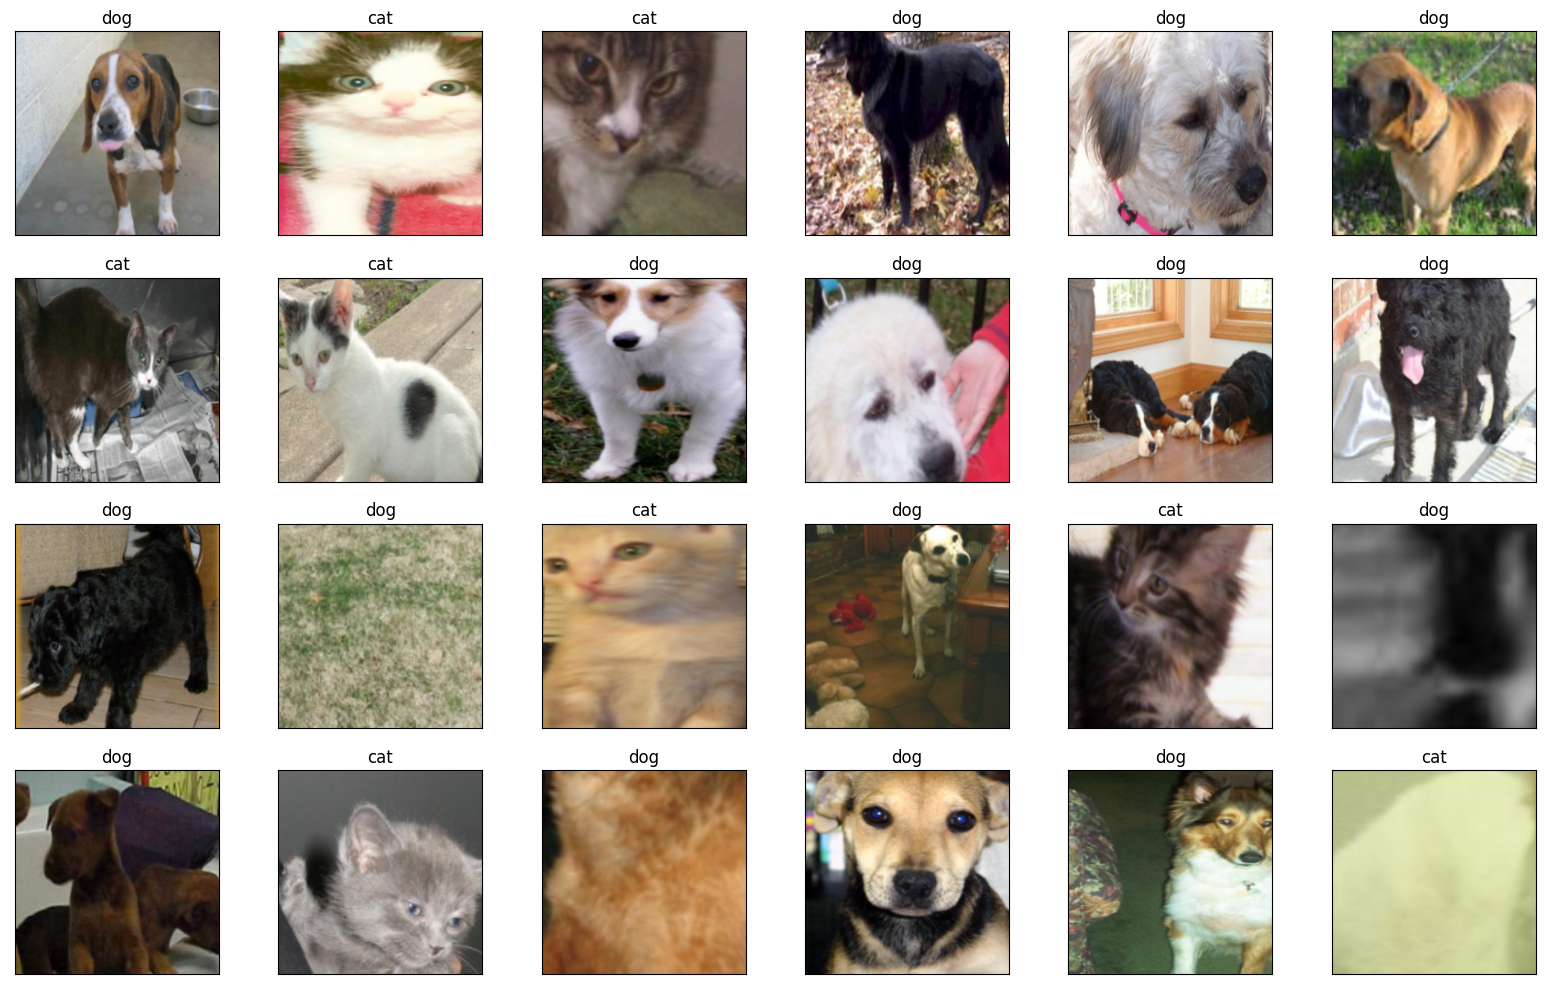

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# train_loader 에서 첫 번째 배치를 가져와 이미지와 라벨을 sample, labels에 저장
samples, labels = next(iter(train_loader))

# 각 클래스의 이름을 숫자와 매칭하여 저장 (총 2개)
classes = {0:'cat',1:'dog'}

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(16, 10)) # 4행 6열의 서브플롯을 생성

for ax, image, label in zip(axs.flatten(), samples, labels):
    image = np.transpose(image.numpy(), (1, 2, 0)) # 차원 변환: (C, H, W) -> (H, W, C)
    
    ax.imshow(image) # 흑백 이미지로 출력
    ax.set_title(classes[label.item()], fontsize=12) # label.item(): torch.Tensor 타입의 스칼라 값(정수)을 얻기 위해 사용
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

# 4.사전 훈련된 모델 내려받기﻿

In [21]:
resnet18 = models.resnet18(pretrained=True)

# 5.사전 훈련된 모델의 파라미터 학습 유무 지정

In [22]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

# 6.ResNet18에 완전연결층 추가

In [23]:
resnet18.fc = nn.Linear(512,2)

# 7.모델의 파라미터 값 확인

In [24]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)


fc.weight tensor([[ 0.0324,  0.0013,  0.0029,  ...,  0.0233, -0.0147, -0.0385],
        [-0.0336, -0.0398,  0.0360,  ...,  0.0057, -0.0255,  0.0349]])
fc.bias tensor([0.0377, 0.0181])


# 8.모델 객체 생성 및 손실 함수 정의

In [25]:
from IPython.display import display

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requres_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 9.모델 학습을 위한 함수 생성

In [26]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0    # 배치마다 손실 누적
        running_corrects = 0  # 배치마다 정확도 누적

        for inputs, labels in dataloaders:
            inputs, labels = inputs.to(device), labels.to(device)
            
            model.to(device)
            outputs = model(inputs) # 데이터(batch)를 모델에 입력하여 출력값 계산
            loss = criterion(outputs, labels) # 손실값 계산
            optimizer.zero_grad() # 이전에 계산된 그래디언트 값 초기화 
            loss.backward() # 손실에 대한 그래디언트 계산
            optimizer.step() # 계산된 그래디언트를 이용하여 가중치 업데이트

            with torch.no_grad():
                preds = torch.argmax(outputs, 1) # 각 행의 최댓값의 인덱스 값 추출
                running_loss += loss.item() * inputs.size(0)   ## 1  # 현재 배치에서 계산된 손실값
                running_corrects += torch.sum(preds == labels) ## 2  # 현재 배치에서 예측값과 정답(label)이 일치한 개수

        epoch_loss = running_loss / len(dataloaders.dataset)             # 전체 데이터셋에 대한 손실 평균
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 전체 데이터셋에 대한 정확도 평균

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item()) # 각 epoch에서의 정확도 값 저장
        loss_history.append(epoch_loss)      # 각 epoch에서의 손실값 저장
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위
        print()

    time_elapsed = time.time() - since # 학습이 끝난 시간 - 학습 시작 시간 = 학습 총 소요 시간
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) # 분/초로 변환하여 출력
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

# 10.파라미터 학습 결과를 옵티마이저에 전달

In [27]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


# 11.모델 학습

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.6282 Acc: 0.6390

Epoch 1/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.4017 Acc: 0.8364

Epoch 2/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.3809 Acc: 0.8156

Epoch 3/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2965 Acc: 0.8675

Epoch 4/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2613 Acc: 0.9091

Epoch 5/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2679 Acc: 0.8935

Epoch 6/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2998 Acc: 0.8571

Epoch 7/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2648 Acc: 0.8961

Epoch 8/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2634 Acc: 0.8649

Epoch 9/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2216 Acc: 0.9091

Epoch 10/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.1969 Acc: 0.9143

Epoch 11/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.1817 Acc: 0.9351

Epoch 12/12
----------


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Loss: 0.2266 Acc: 0.8961

Training complete in 11m 17s
Best Acc: 0.935065


# 12.모델 학습

In [29]:
test_path = './data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


# 13. test 데이터 호출 및 전처리

In [30]:
def eval_model(model, dataloaders, device):
    since = time.time() # 현재 시간
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./data/catanddog/' + '*.pth') ## 1
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models: # 검색된 각 모델 파일에 대해 다음을 수행
        print('Loading model', model_path) 

        model.load_state_dict(torch.load(model_path)) # 모델의 가중치 로드
        model.eval() # 모델을 평가모드로 설정. 이는 학습 중에는 사용되지만 평가중에는 사용되지 않는 기능들을 비활성화
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders: # 각 배치에 대해 다음을 수행
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # 평가중에는 그래디언트가 불필요하기 때문에, 그래디언트 계산 비활성화
                outputs = model(inputs)

            preds = torch.argmax(outputs.data, 1)           
            running_corrects += torch.sum(preds == labels.data)


        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

# 14.test 데이터를 평가 함수에 적용

In [31]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog/00.pth', './data/catanddog/01.pth', './data/catanddog/02.pth', './data/catanddog/03.pth', './data/catanddog/04.pth', './data/catanddog/05.pth', './data/catanddog/06.pth', './data/catanddog/07.pth', './data/catanddog/08.pth', './data/catanddog/09.pth', './data/catanddog/10.pth', './data/catanddog/11.pth', './data/catanddog/12.pth']
Loading model ./data/catanddog/00.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.8673

Loading model ./data/catanddog/01.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9082

Loading model ./data/catanddog/02.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.8980

Loading model ./data/catanddog/03.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9592

Loading model ./data/catanddog/04.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9286

Loading model ./data/catanddog/05.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9592

Loading model ./data/catanddog/06.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9490

Loading model ./data/catanddog/07.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9592

Loading model ./data/catanddog/08.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9082

Loading model ./data/catanddog/09.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9592

Loading model ./data/catanddog/10.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9082

Loading model ./data/catanddog/11.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9490

Loading model ./data/catanddog/12.pth


/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <8E4D9E61-A0A3-30A7-B778-23E3E702B690> /Users/song/opt/anaconda3/envs/python3811/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/song/opt/anaconda3/envs/python3811/lib/libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/python3811/lib/python3.8/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/song/opt/anaconda3/envs/p

Acc: 0.9184

Validation complete in 1m 47s
Best Acc: 0.959184


# 15.train & test 정확도를 그래프로 확인

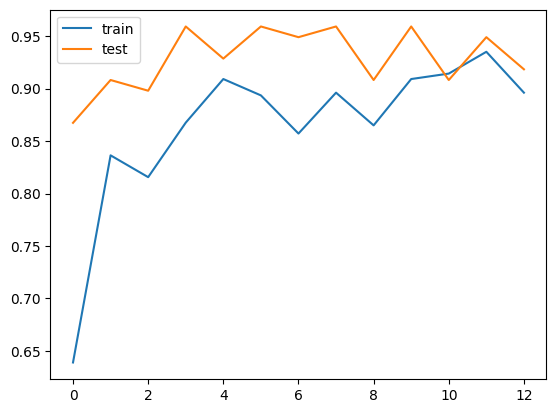

In [38]:
plt.plot(train_acc_hist, label = 'train')
plt.plot(val_acc_hist, label = 'test')

plt.legend(loc='upper left')
plt.show()

# 16. train 데이터의 오차에 대한 그래프 확인

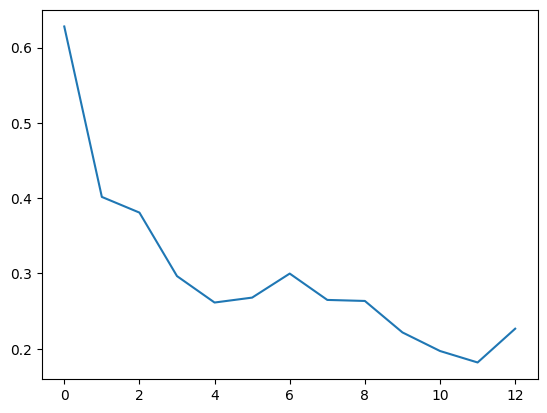

In [33]:
plt.plot(train_loss_hist)
plt.show()